In [21]:
%reset

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D #For 3D Plots

#Required by Jupyter for inlining images
%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Functions:

In [22]:
def match_datasets(df_1, col_index_1, df_2, col_index_2, lower_epsilon, upper_epsilon):
    #col_indexes are the names of the columns to search (eg. 'Time Stamp')
    #Epsilon is the tolerance in seconds
    
    lenDf = len(df_1.columns) + len(df_2.columns)
    df = pd.DataFrame()#columns=list(range(0,lenDf)))
    
    matched = 0 #Number of elements matched
    dropped_df_1 = 0 #Number of elements dropped from df_1
    dropped_df_2 = 0 #Number of elements dropped from df_2
    
    #Ensure Dataframes are sorted by timestamp
    df_1 = df_1.sort_values(by=[col_index_1]).reset_index()
    df_2 = df_2.sort_values(by=[col_index_2]).reset_index()
    
    i = 0 #keeps track of index of df_1
    j = 0 #keeps track of index of df_2
    while i < len(df_1[col_index_1])-1 and j < len(df_2[col_index_2])-1:
        #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
        if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
            #Case 1:
            #Points matched
            matched = matched + 1
            #Add to new DataFrame:
            row = pd.Series(df_1.iloc[i,:].append(df_2.iloc[j,:])).to_frame().T
            df = df.append(row,ignore_index=True)
            #Increment both i and j
            i = i + 1
            j = j + 1
        #Lookahead on i
        elif df_1[col_index_1][i] < df_2[col_index_2][j]:
            #Case 2:
            i = i + 1
            dropped_df_1 = dropped_df_1 + 1 
            while df_1[col_index_1][i] < df_2[col_index_2][j]:
                #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    i = i + 1
                    dropped_df_1 = dropped_df_1 + 1
        elif df_1[col_index_1][i] > df_2[col_index_2][j]:
            #Case 3:
            j = j + 1
            dropped_df_2 = dropped_df_2 + 1 
            while df_1[col_index_1][i] > df_2[col_index_2][j]:
                #if abs(df_1[col_index_1][i]-df_2[col_index_2][j]) < epsilon:
                if (df_1[col_index_1][i]-df_2[col_index_2][j]) > lower_epsilon and (df_1[col_index_1][i]-df_2[col_index_2][j]) < upper_epsilon:
                    #Points Matched
                    matched = matched + 1
                    i = i + 1
                    j = j + 1
                    break
                else:
                    j = j + 1
                    dropped_df_2 = dropped_df_2 + 1
                
        
 
    print('Matched: ' + str(matched))
    print('Dropped from 1st df: ' + str(dropped_df_1))
    print('Dropped from 2nd df: ' + str(dropped_df_2))
    #return pd.DataFrame.from_records(rows)
    #print(rows)  
    
    return df

### Firstly, let's redo the Anomaly detection algorithms but with the corrected BPM data and with the BLMs and Intensities Normalised by Bunches

#### Read and Arrange Separate Datasets:

Note all this is for Beam 1 only for now

#### TL_BPM:

In [23]:
TL_BPM = pd.read_pickle('../Data/Beam1_TL_BPM.pkl')

We're Just Using MSE for now, which is normalised between 0 and 1:

In [24]:
Data = pd.DataFrame(data = {'Time Stamp BPM' : TL_BPM['Time Stamp'], 'BPM MSE': TL_BPM['MSE']})
Data['BPM MSE'] = (Data['BPM MSE']-min(Data['BPM MSE']))/(max(Data['BPM MSE'])-min(Data['BPM MSE']))

#### TDI_BLMs:

In [25]:
BLM = pd.read_pickle('../Data/Beam1_BLM_NN.pkl')

We'll just use Reading 1 since we showed they're highly correlated

In [26]:
BLM = pd.DataFrame(data={'Time Stamp BLM':BLM['Time Stamp'], 'BLM': BLM['Reading 1']})

#### Merge the 2 Datasets

In [27]:
Data = match_datasets(BLM,'Time Stamp BLM',Data,'Time Stamp BPM', 14 ,20)

Matched: 1402
Dropped from 1st df: 492
Dropped from 2nd df: 17


Drop the index columns:

In [28]:
Data = Data.drop(['index'],axis=1)

#### Intensities (LHC-SPS)

In [29]:
Intensities = pd.read_pickle('../Data/intensities.pkl')
Intensities = pd.DataFrame({'Time Stamp SPS': Intensities['Time Stamp']-Intensities['Time Differences'],
                            'Time Stamp LHC': Intensities['Time Stamp'],
                            'LHC-SPS':Intensities['Change in Intensities']})

In [30]:
Intensities.head()

,Time Stamp SPS,Time Stamp LHC,LHC-SPS
0,1.534476e+09,1.534476e+09,-9.420752e+08
1,1.534476e+09,1.534476e+09,-9.910938e+08
2,1.534476e+09,1.534476e+09,1.496010e+09
3,1.534476e+09,1.534476e+09,1.760888e+10
4,1.534477e+09,1.534477e+09,-1.270084e+09


In [31]:
Data = match_datasets(Intensities,'Time Stamp LHC',Data,'Time Stamp BPM', 14 ,20)
Data = Data.drop(['index'],axis=1)

Matched: 893
Dropped from 1st df: 128
Dropped from 2nd df: 1


#### Number of Bunches

In [33]:
Bunches = pd.read_pickle('../Data/Beam1_Bunches.pkl')
Bunches = Bunches.rename(columns={'Time Stamp':'Time Stamp Bunches'})

In [37]:
Temp = Data
Temp2 = Bunches
Temp = match_datasets(Temp,'Time Stamp LHC',Temp2,'Time Stamp Bunches', -5 ,5)

Matched: 886
Dropped from 1st df: 5
Dropped from 2nd df: 37


Text(0,0.5,'Time Stamp Diff')

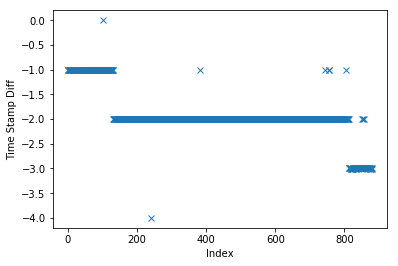

In [38]:
plt.figure()
plt.plot(Temp.index.values,Temp['Time Stamp LHC']-Temp['Time Stamp Bunches'],'x')
plt.xlabel('Index')
plt.ylabel('Time Stamp Diff')

In [39]:
Data = match_datasets(Data,'Time Stamp LHC',Bunches,'Time Stamp Bunches', -5 ,5)

Matched: 886
Dropped from 1st df: 5
Dropped from 2nd df: 37


In [40]:
Data = Data.drop(['index'],axis=1)

In [41]:
Data.head()

,Time Stamp SPS,Time Stamp LHC,LHC-SPS,Time Stamp BLM,BLM,Time Stamp BPM,BPM MSE,Time Stamp Bunches,Number of Bunches
0,1.534476e+09,1.534476e+09,-9.420752e+08,1.534476e+09,0.002390,1.534476e+09,0.000000,1.534476e+09,13.0
1,1.534476e+09,1.534476e+09,-9.910938e+08,1.534476e+09,0.003960,1.534476e+09,0.013231,1.534476e+09,109.0
2,1.534476e+09,1.534476e+09,1.496010e+09,1.534476e+09,0.002312,1.534476e+09,0.005537,1.534476e+09,121.0
3,1.534476e+09,1.534476e+09,1.760888e+10,1.534476e+09,0.004158,1.534476e+09,0.008761,1.534476e+09,265.0
4,1.534477e+09,1.534477e+09,-1.270084e+09,1.534477e+09,0.003327,1.534477e+09,0.011608,1.534477e+09,277.0


#### Normalise by Bunches, then Normalise betweeen 0 and 1

In [42]:
Data['LHC-SPS']=Data['LHC-SPS']/Data['Number of Bunches']
Data['BLM']=Data['BLM']/Data['Number of Bunches']

In [43]:
Data['LHC-SPS'] = (Data['LHC-SPS']-min(Data['LHC-SPS']))/(max(Data['LHC-SPS'])-min(Data['LHC-SPS']))
Data['BLM'] = (Data['BLM']-min(Data['BLM']))/(max(Data['BLM'])-min(Data['BLM']))

## Anomaly Detection Time:

In [44]:
from sklearn.cluster import DBSCAN

In [45]:
X = pd.DataFrame(data={'LHC-SPS':Data['LHC-SPS'],'BLM':Data['BLM'],'BPM MSE':Data['BPM MSE']})
#n_jobs=-1 means use all processors
#########################################
#This seems to work well:
clustering = DBSCAN(eps=0.3,min_samples=50,n_jobs=-1).fit(X)

In [46]:
#clustering.labels_
X['Predicted Value'] = clustering.labels_
is_anomaly = X['Predicted Value']==-1
Anomalies = X[is_anomaly]

not_anomaly = X['Predicted Value']!=-1
Inliers = X[not_anomaly]

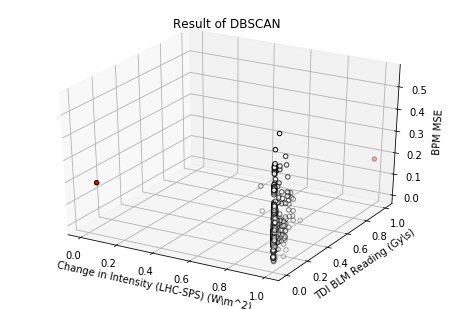

In [47]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['LHC-SPS'],Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['LHC-SPS'],Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of DBSCAN')
plt.show()

### LOF:

In [48]:
from sklearn.neighbors import LocalOutlierFactor

In [49]:
X = pd.DataFrame(data={'LHC-SPS':Data['LHC-SPS'],'BLM':Data['BLM'],'BPM MSE':Data['BPM MSE']})
lof = LocalOutlierFactor(n_neighbors=20,contamination=0.01, n_jobs=-1).fit_predict(X)

/home/marc/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [50]:
X['Predicted Value'] = lof
is_anomaly = X['Predicted Value']==-1
Anomalies = X[is_anomaly]

not_anomaly = X['Predicted Value']!=-1
Inliers = X[not_anomaly]

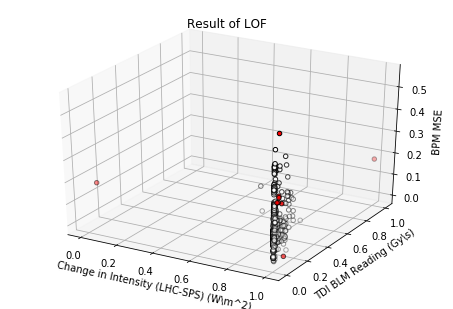

In [52]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(Anomalies['LHC-SPS'],Anomalies['BLM'],Anomalies['BPM MSE'],c='red',
                edgecolor='k', s=20)
ax.scatter(Inliers['LHC-SPS'],Inliers['BLM'],Inliers['BPM MSE'],c='white',
                edgecolor='k', s=20)
ax.set_xlabel('Change in Intensity (LHC-SPS) (W\m^2)')
ax.set_ylabel('TDI BLM Reading (Gy\s)')
ax.set_zlabel('BPM MSE')
ax.set_title('Result of LOF')
plt.show()